# Data Representations

Depending on requirements, there can be many ways to represent data.

## Objects and Aliasing

An  object  is  a  value  with  a  small,  fixed  set  of fields holding further values.    For instance,  an object  standing  for a 
student might contain a  field for the student ID (a positive integer) and a 
field for  the  student's  name  (a  string  of  text).

For us, objects are mutable, meaning that we can change the values of 
an object's fields after the object is first created.  Other pieces of code 
may be holding references to that same object, and they will be able to 
see the field values changing.  One place that references are stashed 
are in the fields of other objects.  The chance for multiple contexts (be 
they  object  fields  or  other  spots)  to  reference  the  same  object  is  called 
aliasing. Aliasing  can  lead  to  remarkably  tricky-to-debug  mistakes 
in code

### A Flat Representation of Data

In this lecture, we wish to represent the grades of students taking different psets. The full set of data consists of:
- A set of students, each with an ID and a name
- A set of psets, each with an ID and a point total
- A set of grade entries, each with a student ID, pset ID, and point
total

We can represent the data as a set of tables, much as they might be
laid out in a spreadsheet.

**Students**
| ID# | Name |
|-----------|--|
| 1 | Alice |
| 2 | Bob |
| 3 | Charlie |

<br>

**Psets**
| ID# | Points Available |
|--------|--|
| 1 | 10 |
| 2 | 20 |
| 3 | 30 |

<br>

**Grades**
| Student ID | Pset ID | Points Earned |
|---------|--|--|
| 1 | 1 | 10 |
| 1 | 2 | 18 |
| 1 | 3 | 25 |
| 2 | 3 | 15 |
| 3 | 3 | 10 |

This is a relatonal database model where we have *rows* in tables. Some columns are *keys* which are unique identifiers. Each table is represented as a list of objects.

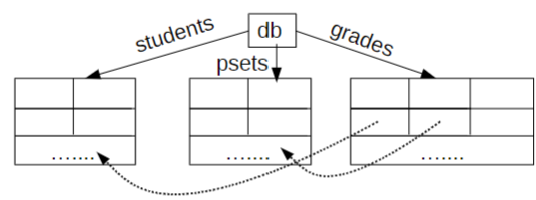

In [48]:
## Some helper functions we'll be reusing below

#returns the next item in a generator
def one(gen):
    return next(gen, None)

#each of these index into a dict into a dict
def get(dict, key):
    if dict == None:
        return None
    elif key in dict:
        return dict[key]
    else:
        return None

def get2(dict1, key1, key2):
    dict2 = get(dict1, key1)
    if dict2:
        return get(dict2, key2)
    else:
        return None

def get3(dict1, key1, key2, key3):
    dict3 = get2(dict1, key1, key2)
    if dict3:
        return get(dict3, key3)
    else:
        return None

def get4(dict1, key1, key2, key3, key4):
    dict4 = get3(dict1, key1, key2, key3)
    if dict4:
        return get(dict4, key4)
    else:
        return None

# Here's a helper function that embodies a code pattern we used in the last version,
# to add to a nested dictionary.
def add2(dict1, key1, key2, value):
    if key1 not in dict1:
        dict1[key1] = {}

    dict1[key1][key2] = value

#### 1. Flat Data Structure

This makes grades a dictionary keyed on pairs of student IDs and pset IDs, as in `gradeOn`

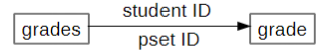

In [49]:
## Version #1: three tables, each represented as a Python list of flat dictionaries

# Create a new empty database.
def empty():
    return {"students": [],
            "psets": [],
            "grades": []}

# Add a new student to the database.
def addStudent(db, student_id, student_name):
    db["students"].append({"id": student_id,
                           "name": student_name})

# Return the ID of the student with a given name, or None if that name isn't found.
def studentIdFromName(db, student_name):
    return one(student["id"]
               for student in db["students"]
               if student["name"] == student_name)

# Return the name of the student with a given ID, or None if that ID isn't found.
def studentNameFromId(db, student_id):
    return one(student["name"]
               for student in db["students"]
               if student["id"] == student_id)

# Add a new pset to the database.
def addPset(db, pset_id, pset_total_points):
    db["psets"].append({"id": pset_id,
                        "points": pset_total_points})

# Return the point value of the pset with a given ID, or None if that ID isn't found.
def psetPointsFromId(db, pset_id):
    return one(pset["points"]
               for pset in db["psets"]
               if pset["id"] == pset_id)

# Record a student's grade on a pset.
def addGrade(db, student_id, pset_id, points):
    db["grades"].append({"student": student_id,
                         "pset": pset_id,
                         "points": points})

# Which grade did this student get on this pset?  (Returns None if no grade has been
# recorded.)
def gradeOn(db, student_id, pset_id):
    return one(grade["points"]
               for grade in db["grades"]
               if grade["student"] == student_id
               if grade["pset"] == pset_id)

# Return all of a student's grades, as a dictionary from pset IDs to points.
def studentGrades(db, student_id):
    return {grade["pset"]: grade["points"]
            for grade in db["grades"]
            if grade["student"] == student_id}

# Return all grades on a pset, as a dictionary from student names to grades.
# Notice that we're making it interesting by working with student names instead of IDs.
# The grades table doesn't include student names directly!
def gradesOnPset(db, pset_id):
    return {student["name"]: grade["points"]
            for grade in db["grades"]
            if grade["pset"] == pset_id
            for student in db["students"]
            if student["id"] == grade["student"]}

# OK, time for the fanciest report yet.
# Imagine it's the end of the semester, and the course staff need the final list of
# all scores for all students.
# The registrar wants this information as a spreadsheet that includes student IDs,
# names, and overall scores.
# However, the registrar doesn't want to hear anything about the details of which
# assignments there were.
# Let's assume that (1) psets are the only factor in grades and (2) each pset is
# weighted equally.

# To start with, let's implement a version of studentGrades that:
# (1) includes zeroes for missing grades,
# (2) divides by the point total for each pset, and
# (3) returns a list of scores.
# One more helper function is useful first.
def gradeOnWeighted(db, student_id, pset):
    grade = gradeOn(db, student_id, pset["id"])
    if grade == None:
        return 0
    else:
        return grade * 1.0 / pset["points"]
        # Note the multiplication by 1.0 to switch to using rational numbers
        # and avoid rounding!
def studentGradesWeighted(db, student_id):
    return [gradeOnWeighted(db, student_id, pset)
            for pset in db["psets"]]

# Next, computing the final grade of a student.
def finalGradeOf(db, student_id):
    grades = studentGradesWeighted(db, student_id)
    return round(sum(grades) / len(grades) * 100, 1)

# Finally, computing for all students.
def finalGrades(db):
    return [{"id": student["id"],
             "name": student["name"],
             "grade": finalGradeOf(db, student["id"])}
            for student in db["students"]]


db = empty()

addStudent(db, 1, "Alice")
addStudent(db, 2, "Bob")
addStudent(db, 3, "Charlie")

addPset(db, 1, 10)
addPset(db, 2, 20)
addPset(db, 3, 30)

addGrade(db, 1, 1, 10)
addGrade(db, 1, 2, 18)
addGrade(db, 1, 3, 25)
addGrade(db, 2, 3, 15)
addGrade(db, 3, 3, 10)

assert studentIdFromName(db, "Bob") == 2
assert studentIdFromName(db, "Doug") == None

assert studentNameFromId(db, 3) == "Charlie"
assert studentNameFromId(db, 4) == None

assert psetPointsFromId(db, 2) == 20
assert psetPointsFromId(db, 8) == None

assert gradeOn(db, 1, 3) == 25
assert gradeOn(db, 2, 1) == None

assert studentGrades(db, 1) == {1: 10, 2: 18, 3: 25}

assert gradesOnPset(db, 3) == {"Alice": 25, "Bob": 15, "Charlie": 10}

print (db["grades"])


[{'student': 1, 'pset': 1, 'points': 10}, {'student': 1, 'pset': 2, 'points': 18}, {'student': 1, 'pset': 3, 'points': 25}, {'student': 2, 'pset': 3, 'points': 15}, {'student': 3, 'pset': 3, 'points': 10}]


#### 2. Using a Nested Dictionary

Taking the simple step of encoding each appropriate table as a dictionary over its key. Chooses the  `[Student ID] |-> [Pset ID] |-> [Points]` mapping for grades. ALL grades for one student are therefore easily looked up. All grades on one pset still need one loop through the items in the grades dictionary.

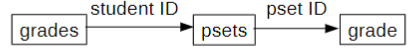

In [50]:
## Version #2: dictionaries instead of lists

# No header comments for the functions anymore, as each function does the same thing, at a high level, as it did in the last version.

def empty():
    return {"students": {},
            "psets": {},
            "grades": {}}
# There's a good chance you can guess how "students" and "psets" work as dictionaries.
# It's natural to use each kind of ID as a key.
# Grades are less obvious.  There are at least three reasonable dictionary choices:
#  [Student ID] |-> [Pset ID] |-> [Points]
#  [Pset ID] |-> [Student ID] |-> [Points]
#  [(Student ID, Pset ID)] |-> [Points]
# We're going to use the first one, which is optimized for fast lookup of grades by
# students.

def addStudent(db, student_id, student_name):
    db["students"][student_id] = student_name

def studentIdFromName(db, student_name):
    return one(id
               for id, name in db["students"].items()
               if name == student_name)

def studentNameFromId(db, student_id):
    return get(db["students"], student_id)

def addPset(db, pset_id, pset_total_points):
    db["psets"][pset_id] = pset_total_points

def psetPointsFromId(db, pset_id):
    return get(db["psets"], pset_id)

def addGrade(db, student_id, pset_id, points):
    if student_id not in db["grades"]:
        db["grades"][student_id] = {}

    db["grades"][student_id][pset_id] = points

def gradeOn(db, student_id, pset_id):
    return get2(db["grades"], student_id, pset_id)

# Our representation of grades really shines here!
# simply return the dict of grades, for this student
def studentGrades(db, student_id):
    return get(db["grades"], student_id)

def gradesOnPset(db, pset_id):
    return {db["students"][student]: psets[pset_id]
            for student, psets in db["grades"].items()
            if pset_id in psets}

db = empty()

addStudent(db, 1, "Alice")
addStudent(db, 2, "Bob")
addStudent(db, 3, "Charlie")

addPset(db, 1, 10)
addPset(db, 2, 20)
addPset(db, 3, 30)

addGrade(db, 1, 1, 10)
addGrade(db, 1, 2, 18)
addGrade(db, 1, 3, 25)
addGrade(db, 2, 3, 15)
addGrade(db, 3, 3, 10)

assert studentIdFromName(db, "Bob") == 2
assert studentIdFromName(db, "Doug") == None

assert studentNameFromId(db, 3) == "Charlie"
assert studentNameFromId(db, 4) == None

assert psetPointsFromId(db, 2) == 20
assert psetPointsFromId(db, 8) == None

assert gradeOn(db, 1, 3) == 25
assert gradeOn(db, 2, 1) == None

assert studentGrades(db, 1) == {1: 10, 2: 18, 3: 25}

assert gradesOnPset(db, 3) == {"Alice": 25, "Bob": 15, "Charlie": 10}

print (db["grades"])


{1: {1: 10, 2: 18, 3: 25}, 2: {3: 15}, 3: {3: 10}}


#### 3. Bi-directional Dictionaries

To support multiple directions of efficient lookup, use multiple dictionaries to encode *one* table, mapping to the key type. Student ID to Student Name and Student Name to Student ID. 

For grades, have two mappings  `[Student ID] |-> [Pset ID] |-> [Points]` and `[Pset ID] |-> [Student ID] |-> [Points]`. Student ID from Name gets more efficient -- just one lookup. Grades on a pset gets more efficient. Check quickly if at least one student did the pset (!), by using the second mapping. We get a dictionary of student IDs to points on a particular pset. We need to loop through the students to map student names to points as required. Previously, we had to loop through ALL the grades in the database to find the grades for a particular pset.

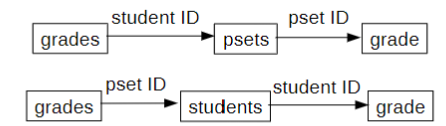

The small downside is that updating the database is a little more work and needs some care to maintain consistency.


In [51]:
## Version #3: redundant dictionaries to support fast implementations of more operations

def empty():
    #bidrectional for student_name<==>student_id
    return {"studentsById": {},
            "studentsByName": {},

            "psets": {},
            
            "gradesByStudent": {},
            "gradesByPset": {}}

def addStudent(db, student_id, student_name):
    db["studentsById"][student_id] = student_name
    db["studentsByName"][student_name] = student_id

def studentIdFromName(db, student_name):
    return get(db["studentsByName"], student_name)

def studentNameFromId(db, student_id):
    return get(db["studentsById"], student_id)

def addPset(db, pset_id, pset_total_points):
    db["psets"][pset_id] = pset_total_points

def psetPointsFromId(db, pset_id):
    return get(db["psets"], pset_id)

def addGrade(db, student_id, pset_id, points):
    #add to both bidirectional nested dicts
    add2(db["gradesByStudent"], student_id, pset_id, points)
    add2(db["gradesByPset"], pset_id, student_id, points)

def gradeOn(db, student_id, pset_id):
    return get2(db["gradesByStudent"], student_id, pset_id)

def studentGrades(db, student_id):
    return get(db["gradesByStudent"], student_id)

def gradesOnPset(db, pset_id):
    students = get(db["gradesByPset"], pset_id)
    if students:
        return {db["studentsById"][student_id]: points
            for student_id, points in students.items()}
    else:
        return {}

db = empty()

addStudent(db, 1, "Alice")
addStudent(db, 2, "Bob")
addStudent(db, 3, "Charlie")

addPset(db, 1, 10)
addPset(db, 2, 20)
addPset(db, 3, 30)

addGrade(db, 1, 1, 10)
addGrade(db, 1, 2, 18)
addGrade(db, 1, 3, 25)
addGrade(db, 2, 3, 15)
addGrade(db, 3, 3, 10)

assert studentIdFromName(db, "Bob") == 2
assert studentIdFromName(db, "Doug") == None

assert studentNameFromId(db, 3) == "Charlie"
assert studentNameFromId(db, 4) == None

assert psetPointsFromId(db, 2) == 20
assert psetPointsFromId(db, 8) == None

assert gradeOn(db, 1, 3) == 25
assert gradeOn(db, 2, 1) == None

assert studentGrades(db, 1) == {1: 10, 2: 18, 3: 25}

assert gradesOnPset(db, 3) == {"Alice": 25, "Bob": 15, "Charlie": 10}


#### Redundancy for Speed

We are free to encode data in a way that is *redundant*, where, say, we
could remove some fields of an object, in a way where the contents of
those fields could still be reconstructed systematically from the contents of
remaining   fields.     

Why   bother   keeping   redundant   information?     It's
often easier to code most operations in less redundant representations.
However, some  operations  can be  much  faster  with redundant  data
structures.

In   our   class-grades   example,   we   create a duplicate dictionary in the opposite direction to speed up operations:
1. Store   dictionaries   for  both directions  of   the   mapping   between student IDs and student names.
1. Provide  both of the nested dictionary representations of grades
that   we   considered   above,   so   that   we   can   support   either
direction efficiently

#### 4. Bi-directional Nested Dicts - Objects + Aliasing

Actually, those multiple dictionaries could all be mapping to the *same mutable Python objects* (dictionaries). We have student objects that are dictionaries with "id" and "name" keys with corresponding id and name values, pset objects with "id" and "points" keys, and grade objects with "student" (id), "pset" (id) and "points" keys. All these objects represent one row, and the different outer dictionaries references these same objects hence aliasing. 

When you return an object rather than just the id, name, or points, the caller gets more information (how you got to the id, name or points through dictionary lookups).


In [52]:
## Version #4: now all dictionaries for a particular sort of
## entity map to the same underlying _objects_.

def empty():
    return {"studentsById": {},
            "studentsByName": {},
            "psets": {},
            "gradesByStudent": {},
            "gradesByPset": {}}

def addStudent(db, student_id, student_name):
    student = {"id": student_id,
               "name": student_name}
    #referencing the same dict object!
    db["studentsById"][student_id] = student
    db["studentsByName"][student_name] = student

#accepts a 'student' dict
def studentId(student):
    return get(student, "id")
def studentName(student):
    return get(student, "name")

def studentFromName(db, student_name):
    #get the object from the name
    return get(db["studentsByName"], student_name)

def studentIdFromName(db, student_name):
    return studentId(studentFromName(db, student_name))

def studentFromId(db, student_id):
    return get(db["studentsById"], student_id)

def studentNameFromId(db, student_id):
    return studentName(studentFromId(db, student_id))

def addPset(db, pset_id, pset_total_points):
    pset = {"id": pset_id,
            "points": pset_total_points}

    db["psets"][pset_id] = pset

def psetPoints(pset):
    return get(pset, "points")

def psetFromId(db, pset_id):
    return get(db["psets"], pset_id)

def psetPointsFromId(db, pset_id):
    return psetPoints(psetFromId(db, pset_id))

def addGrade(db, student_id, pset_id, points):
    grade = {"student": student_id,
             "pset": pset_id,
             "points": points}
    #reference the same object instead of creating duplicates
    add2(db["gradesByStudent"], student_id, pset_id, grade)
    add2(db["gradesByPset"], pset_id, student_id, grade)

def gradeOn(db, student_id, pset_id):
    return get3(db["gradesByStudent"], student_id, pset_id, "points")

def studentGrades(db, student_id):
    return {grade["pset"]: grade["points"]
            for grade in get(db["gradesByStudent"], student_id).values()}

def gradesOnPset(db, pset_id):
    students = get(db["gradesByPset"], pset_id)
    if students:
        return {db["studentsById"][student_id]["name"]: grade["points"]
            for student_id, grade in students.items()}
    else:
        return {}


db = empty()

addStudent(db, 1, "Alice")
addStudent(db, 2, "Bob")
addStudent(db, 3, "Charlie")

addPset(db, 1, 10)
addPset(db, 2, 20)
addPset(db, 3, 30)

addGrade(db, 1, 1, 10)
addGrade(db, 1, 2, 18)
addGrade(db, 1, 3, 25)
addGrade(db, 2, 3, 15)
addGrade(db, 3, 3, 10)

assert studentIdFromName(db, "Bob") == 2
assert studentIdFromName(db, "Doug") == None

assert studentNameFromId(db, 3) == "Charlie"
assert studentNameFromId(db, 4) == None

assert psetPointsFromId(db, 2) == 20
assert psetPointsFromId(db, 8) == None

assert gradeOn(db, 1, 3) == 25
assert gradeOn(db, 2, 1) == None

assert studentGrades(db, 1) == {1: 10, 2: 18, 3: 25}

assert gradesOnPset(db, 3) == {"Alice": 25, "Bob": 15, "Charlie": 10}


#### 5. Nesting Dictionaries Within Objects

We can cut down on extra dictionary lookups by giving each student its own dictionary of grades, keyed by pset ID.     We   can   also   do   the symmetrical   thing   for   psets,   giving   each   one   its   own   dictionary   of grades keyed by student ID. This innermost dict is one grade, and is accessible by both `student` and `pset` object.

We remove the two grades mappings, and only have student by id, student by name and psets at the top level. However, psets has a grades dictionary inside it. The grade object doesn't change from the obj version, but updating a grade does. Finding grades on a pset has a clean and efficient implementation (no need to check that at least one student did the pset).


In [53]:
## Version #5: let's add some dictionaries nested inside of dictionaries.

def empty():
    return {"studentsById": {},
            "studentsByName": {},
            "psets": {}}

def addStudent(db, student_id, student_name):
    student = {"id": student_id,
               "name": student_name,
               "grades": {}} #each student has a dict of grades

    db["studentsById"][student_id] = student
    db["studentsByName"][student_name] = student

def studentId(student):
    return get(student, "id")
def studentName(student):
    return get(student, "name")

def studentFromName(db, student_name):
    return get(db["studentsByName"], student_name)

def studentIdFromName(db, student_name):
    return studentId(studentFromName(db, student_name))

def studentFromId(db, student_id):
    return get(db["studentsById"], student_id)

def studentNameFromId(db, student_id):
    return studentName(studentFromId(db, student_id))

def addPset(db, pset_id, pset_total_points):
    pset = {"id": pset_id,
            "points": pset_total_points,
            "grades": {}}

    db["psets"][pset_id] = pset

def psetPoints(pset):
    return get(pset, "points")

def psetFromId(db, pset_id):
    return get(db["psets"], pset_id)

def psetPointsFromId(db, pset_id):
    return psetPoints(psetFromId(db, pset_id))

def addGrade(db, student_id, pset_id, points):
    grade = {"student": student_id,
             "pset": pset_id,
             "points": points}

    #get the student object
    student = studentFromId(db, student_id)
    student["grades"][pset_id] = grade

    #get the pset object
    pset = psetFromId(db, pset_id)
    pset["grades"][student_id] = grade

def gradeOn(db, student_id, pset_id):
    return get4(db["studentsById"], student_id, "grades", pset_id, "points")

def studentGrades(db, student_id):
    return {grade["pset"]: grade["points"]
            for grade in get2(db["studentsById"], student_id, "grades").values()}

def gradesOnPset(db, pset_id):
    return {db["studentsById"][grade["student"]]["name"]: grade["points"]
            for grade in get2(db["psets"], pset_id, "grades").values()}

def gradeOnWeighted(db, student_id, pset_id, pset_points):
    grade = gradeOn(db, student_id, pset_id)
    if grade == None:
        return 0
    else:
        return grade * 1.0 / pset_points
def studentGradesWeighted(db, student_id):
    return [gradeOnWeighted(db, student_id, pset["id"], pset["points"])
            for pset in db["psets"].values()]

def finalGradeOf(db, student_id):
    grades = studentGradesWeighted(db, student_id)
    return round(sum(grades) / len(grades) * 100, 1)

def finalGrades(db):
    return [{"id": student["id"],
             "name": student["name"],
             "grade": finalGradeOf(db, student["id"])}
            for student in db["studentsById"].values()]

# Motivating the next version of this code:
# here's a slow way to get the average score on a pset,
# among those students who have had grades recorded.
def averageOnPset(db, pset_id):
    pset = psetFromId(db, pset_id)
    return round(sum([grade["points"] for grade in pset["grades"].values()])
                 * 100.0 / pset["points"] / len(pset["grades"]), 1)

def tests():
    db = empty()

    addStudent(db, 1, "Alice")
    addStudent(db, 2, "Bob")
    addStudent(db, 3, "Charlie")

    addPset(db, 1, 10)
    addPset(db, 2, 20)
    addPset(db, 3, 30)

    addGrade(db, 1, 1, 10)
    addGrade(db, 1, 2, 18)
    addGrade(db, 1, 3, 25)
    addGrade(db, 2, 3, 15)
    addGrade(db, 3, 3, 10)

    assert studentIdFromName(db, "Bob") == 2
    assert studentIdFromName(db, "Doug") == None

    assert studentNameFromId(db, 3) == "Charlie"
    assert studentNameFromId(db, 4) == None

    assert psetPointsFromId(db, 2) == 20
    assert psetPointsFromId(db, 8) == None

    assert gradeOn(db, 1, 3) == 25
    assert gradeOn(db, 2, 1) == None

    assert studentGrades(db, 1) == {1: 10, 2: 18, 3: 25}

    assert gradesOnPset(db, 3) == {"Alice": 25, "Bob": 15, "Charlie": 10}

    print (finalGrades(db))

    assert averageOnPset(db, 3) == 55.6


## Caching

A simple trick is to store, in each pset, the sum of all grades recorded
for   that   pset   so   far.     Now   computing   the   average of one pset  is   as   simple   as
dividing the sum by the appropriate number, which runs in $O(1)$.

We have to do a little extra work each time we record a grade, but that work is also $O(1)$ each time.

In [47]:
## Version #6: caching sums to support fast average calculation

def empty():
    return {"studentsById": {},
            "studentsByName": {},
            "psets": {}}

def addStudent(db, student_id, student_name):
    student = {"id": student_id,
               "name": student_name,
               "grades": {}}

    db["studentsById"][student_id] = student
    db["studentsByName"][student_name] = student

def studentId(student):
    return get(student, "id")
def studentName(student):
    return get(student, "name")

def studentFromName(db, student_name):
    return get(db["studentsByName"], student_name)

def studentIdFromName(db, student_name):
    return studentId(studentFromName(db, student_name))

def studentFromId(db, student_id):
    return get(db["studentsById"], student_id)

def studentNameFromId(db, student_id):
    return studentName(studentFromId(db, student_id))

def addPset(db, pset_id, pset_total_points):
    pset = {"id": pset_id,
            "points": pset_total_points,
            "grades": {},
            "gradesSum": 0}

    db["psets"][pset_id] = pset

def psetPoints(pset):
    return get(pset, "points")

def psetFromId(db, pset_id):
    return get(db["psets"], pset_id)

def psetPointsFromId(db, pset_id):
    return psetPoints(psetFromId(db, pset_id))

def addGrade(db, student_id, pset_id, points):
    grade = {"student": student_id,
             "pset": pset_id,
             "points": points}

    student = studentFromId(db, student_id)
    student["grades"][pset_id] = grade

    pset = psetFromId(db, pset_id)
    pset["grades"][student_id] = grade
    #running sum of grades in this pset!
    pset["gradesSum"] += points

def gradeOn(db, student_id, pset_id):
    return get4(db["studentsById"], student_id, "grades", pset_id, "points")

def studentGrades(db, student_id):
    return {grade["pset"]: grade["points"]
            for grade in get2(db["studentsById"], student_id, "grades").values()}

def gradesOnPset(db, pset_id):
    return {db["studentsById"][grade["student"]]["name"]: grade["points"]
            for grade in get2(db["psets"], pset_id, "grades").values()}

def gradeOnWeighted(db, student_id, pset_id, pset_points):
    grade = gradeOn(db, student_id, pset_id)
    if grade == None:
        return 0
    else:
        return grade * 1.0 / pset_points
def studentGradesWeighted(db, student_id):
    return [gradeOnWeighted(db, student_id, pset["id"], pset["points"])
            for pset in db["psets"].values()]

def finalGradeOf(db, student_id):
    grades = studentGradesWeighted(db, student_id)
    return round(sum(grades) / len(grades) * 100, 1)

def finalGrades(db):
    return [{"id": student["id"],
             "name": student["name"],
             "grade": finalGradeOf(db, student["id"])}
            for student in db["studentsById"].values()]

def averageOnPset(db, pset_id):
    pset = psetFromId(db, pset_id)
    #no need to iterate over all the students in this pset
    return round(pset["gradesSum"] * 100.0 / pset["points"] / len(pset["grades"]), 1)


def tests():
    db = empty()

    addStudent(db, 1, "Alice")
    addStudent(db, 2, "Bob")
    addStudent(db, 3, "Charlie")

    addPset(db, 1, 10)
    addPset(db, 2, 20)
    addPset(db, 3, 30)

    addGrade(db, 1, 1, 10)
    addGrade(db, 1, 2, 18)
    addGrade(db, 1, 3, 25)
    addGrade(db, 2, 3, 15)
    addGrade(db, 3, 3, 10)

    assert studentIdFromName(db, "Bob") == 2
    assert studentIdFromName(db, "Doug") == None

    assert studentNameFromId(db, 3) == "Charlie"
    assert studentNameFromId(db, 4) == None

    assert psetPointsFromId(db, 2) == 20
    assert psetPointsFromId(db, 8) == None

    assert gradeOn(db, 1, 3) == 25
    assert gradeOn(db, 2, 1) == None

    assert studentGrades(db, 1) == {1: 10, 2: 18, 3: 25}

    assert gradesOnPset(db, 3) == {"Alice": 25, "Bob": 15, "Charlie": 10}

    print (finalGrades(db))

    assert averageOnPset(db, 3) == 55.6
